http://preview.d2l.ai/d2l-en/master/chapter_recommender-systems/fm.html

In [1]:
from d2l import mxnet as d2l
from mxnet import init, gluon, np, npx
from mxnet.gluon import nn
import os
import sys
npx.set_np()

In [2]:
class FM(nn.Block):
    def __init__(self, field_dims, num_factors):
        super(FM, self).__init__()
        num_inputs = int(sum(field_dims))
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.linear_layer = nn.Dense(1, use_bias=True)

    def forward(self, x):
        square_of_sum = np.sum(self.embedding(x), axis=1) ** 2
        sum_of_square = np.sum(self.embedding(x) ** 2, axis=1)
        x = self.linear_layer(self.fc(x).sum(1)) \
            + 0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True)
        x = npx.sigmoid(x)
        return x

In [3]:
batch_size = 2048
data_dir = d2l.download_extract('ctr')
train_data = d2l.CTRDataset(os.path.join(data_dir, 'train.csv'))
test_data = d2l.CTRDataset(os.path.join(data_dir, 'test.csv'),
                           feat_mapper=train_data.feat_mapper,
                           defaults=train_data.defaults)
train_iter = gluon.data.DataLoader(
    train_data, shuffle=True, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())
test_iter = gluon.data.DataLoader(
    test_data, shuffle=False, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())

loss 0.504, train acc 0.266, test acc 0.262
8220.1 examples/sec on [cpu(0)]


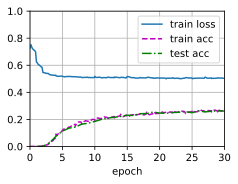

In [4]:
devices = d2l.try_all_gpus()
net = FM(train_data.field_dims, num_factors=20)
net.initialize(init.Xavier(), ctx=devices)
lr, num_epochs, optimizer = 0.02, 30, 'adam'
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {'learning_rate': lr})
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)